In [1]:
from typing import Union, Optional, Tuple
import torch
from diffusers import DDIMScheduler
import numpy as np
from PIL import Image
import os
import torch.nn.functional as F
from torchgeometry.core.conversions import deg2rad
from torchgeometry.core.homography_warper import homography_warp
import matplotlib.pyplot as plt


class SO2_warper():
    def __init__(self):
        pass

    # Code from
    # https://kornia.readthedocs.io/en/v0.1.2/_modules/torchgeometry/core/imgwarp.html
    
    def get_perspective_transform(self, src, dst):
        r"""Calculates a perspective transform from four pairs of the corresponding
        points.

        The function calculates the matrix of a perspective transform so that:

        .. math ::

            \begin{bmatrix}
            t_{i}x_{i}^{'} \\
            t_{i}y_{i}^{'} \\
            t_{i} \\
            \end{bmatrix}
            =
            \textbf{map_matrix} \cdot
            \begin{bmatrix}
            x_{i} \\
            y_{i} \\
            1 \\
            \end{bmatrix}

        where

        .. math ::
            dst(i) = (x_{i}^{'},y_{i}^{'}), src(i) = (x_{i}, y_{i}), i = 0,1,2,3

        Args:
            src (Tensor): coordinates of quadrangle vertices in the source image.
            dst (Tensor): coordinates of the corresponding quadrangle vertices in
                the destination image.

        Returns:
            Tensor: the perspective transformation.

        Shape:
            - Input: :math:`(B, 4, 2)` and :math:`(B, 4, 2)`
            - Output: :math:`(B, 3, 3)`
        """
        if not torch.is_tensor(src):
            raise TypeError("Input type is not a torch.Tensor. Got {}"
                            .format(type(src)))
        if not torch.is_tensor(dst):
            raise TypeError("Input type is not a torch.Tensor. Got {}"
                            .format(type(dst)))
        if not src.shape[-2:] == (4, 2):
            raise ValueError("Inputs must be a Bx4x2 tensor. Got {}"
                             .format(src.shape))
        if not src.shape == dst.shape:
            raise ValueError("Inputs must have the same shape. Got {}"
                             .format(dst.shape))
        if not (src.shape[0] == dst.shape[0]):
            raise ValueError("Inputs must have same batch size dimension. Got {}"
                             .format(src.shape, dst.shape))

        def ax(p, q):
            ones = torch.ones_like(p)[..., 0:1]
            zeros = torch.zeros_like(p)[..., 0:1]
            return torch.cat(
                [p[:, 0:1], p[:, 1:2], ones, zeros, zeros, zeros,
                 -p[:, 0:1] * q[:, 0:1], -p[:, 1:2] * q[:, 0:1]
                 ], dim=1)

        def ay(p, q):
            ones = torch.ones_like(p)[..., 0:1]
            zeros = torch.zeros_like(p)[..., 0:1]
            return torch.cat(
                [zeros, zeros, zeros, p[:, 0:1], p[:, 1:2], ones,
                 -p[:, 0:1] * q[:, 1:2], -p[:, 1:2] * q[:, 1:2]], dim=1)
        # we build matrix A by using only 4 point correspondence. The linear
        # system is solved with the least square method, so here
        # we could even pass more correspondence
        p = []
        p.append(ax(src[:, 0], dst[:, 0]))
        p.append(ay(src[:, 0], dst[:, 0]))

        p.append(ax(src[:, 1], dst[:, 1]))
        p.append(ay(src[:, 1], dst[:, 1]))

        p.append(ax(src[:, 2], dst[:, 2]))
        p.append(ay(src[:, 2], dst[:, 2]))

        p.append(ax(src[:, 3], dst[:, 3]))
        p.append(ay(src[:, 3], dst[:, 3]))

        # A is Bx8x8
        A = torch.stack(p, dim=1)

        # b is a Bx8x1
        b = torch.stack([
            dst[:, 0:1, 0], dst[:, 0:1, 1],
            dst[:, 1:2, 0], dst[:, 1:2, 1],
            dst[:, 2:3, 0], dst[:, 2:3, 1],
            dst[:, 3:4, 0], dst[:, 3:4, 1],
        ], dim=1)

        # solve the system Ax = b
        # X, LU = torch.gesv(b, A) # Outdated change to solve 2023.07.17 Jaihoon
        X, LU = torch.solve(b, A)

        # create variable to return
        batch_size = src.shape[0]
        M = torch.ones(batch_size, 9, device=src.device, dtype=src.dtype)
        M[..., :8] = torch.squeeze(X, dim=-1)
        return M.view(-1, 3, 3)  # Bx3x3
        

    def get_rotation_matrix2d(self, center, angle, scale, translate=None):
        r"""Calculates an affine matrix of 2D rotation.

        The function calculates the following matrix:

        .. math::
            \begin{bmatrix}
                \alpha & \beta & (1 - \alpha) \cdot \text{x}
                - \beta \cdot \text{y} \\
                -\beta & \alpha & \beta \cdot \text{x}0
                + (1 - \alpha) \cdot \text{y}
            \end{bmatrix}

        where

        .. math::
            \alpha = \text{scale} \cdot cos(\text{angle}) \\
            \beta = \text{scale} \cdot sin(\text{angle})

        The transformation maps the rotation center to itself
        If this is not the target, adjust the shift.

        Args:
            center (Tensor): center of the rotation in the source image.
            angle (Tensor): rotation angle in degrees. Positive values mean
                counter-clockwise rotation (the coordinate origin is assumed to
                be the top-left corner).
            scale (Tensor): isotropic scale factor.

        Returns:
            Tensor: the affine matrix of 2D rotation.

        Shape:
            - Input: :math:`(B, 2)`, :math:`(B)` and :math:`(B)`
            - Output: :math:`(B, 2, 3)`

        Example:
            >>> center = torch.zeros(1, 2)
            >>> scale = torch.ones(1)
            >>> angle = 45. * torch.ones(1)
            >>> M = tgm.get_rotation_matrix2d(center, angle, scale)
            tensor([[[ 0.7071,  0.7071,  0.0000],
                    [-0.7071,  0.7071,  0.0000]]])
        """
        if not torch.is_tensor(center):
            raise TypeError("Input center type is not a torch.Tensor. Got {}"
                            .format(type(center)))
        if not torch.is_tensor(angle):
            raise TypeError("Input angle type is not a torch.Tensor. Got {}"
                            .format(type(angle)))
        if not torch.is_tensor(scale):
            raise TypeError("Input scale type is not a torch.Tensor. Got {}"
                            .format(type(scale)))
        if not (len(center.shape) == 2 and center.shape[1] == 2):
            raise ValueError("Input center must be a Bx2 tensor. Got {}"
                            .format(center.shape))
        if not len(angle.shape) == 1:
            raise ValueError("Input angle must be a B tensor. Got {}"
                            .format(angle.shape))
        if not len(scale.shape) == 1:
            raise ValueError("Input scale must be a B tensor. Got {}"
                            .format(scale.shape))
        if not (center.shape[0] == angle.shape[0] == scale.shape[0]):
            raise ValueError("Inputs must have same batch size dimension. Got {}"
                            .format(center.shape, angle.shape, scale.shape))
        
        # Add translation 2023.07.17
        if translate != None:
            tx, ty = translate[..., 0], translate[..., 1]
        else:
            translate = torch.zeros_like(center)
            tx, ty = translate[..., 0], translate[..., 1]
        print("Translation vector: ", tx, ty)
        
        # convert angle and apply scale
        angle_rad = deg2rad(angle)
        alpha = torch.cos(angle_rad) * scale
        beta = torch.sin(angle_rad) * scale

        # unpack the center to x, y coordinates
        x, y = center[..., 0], center[..., 1]

        # create output tensor
        batch_size, _ = center.shape
        M = torch.zeros(batch_size, 2, 3, device=center.device, dtype=center.dtype)
        M[..., 0, 0] = alpha
        M[..., 0, 1] = beta
        M[..., 0, 2] = (1. - alpha) * x - beta * y + tx
        M[..., 1, 0] = -beta
        M[..., 1, 1] = alpha
        M[..., 1, 2] = beta * x + (1. - alpha) * y + ty
        return M


    def warp_affine(self, 
                    src: torch.Tensor,
                    M: torch.Tensor,
                    dsize: Tuple[int, int],
                    interpolation_mode: Optional[str] = 'bilinear',
                    padding_mode: Optional[str] = 'zeros') -> torch.Tensor:
        r"""Applies an affine transformation to a tensor.

        The function warp_affine transforms the source tensor using
        the specified matrix:

        .. math::
            \text{dst}(x, y) = \text{src} \left( M_{11} x + M_{12} y + M_{13} ,
            M_{21} x + M_{22} y + M_{23} \right )

        Args:
            src (torch.Tensor): input tensor of shape :math:`(B, C, H, W)`.
            M (torch.Tensor): affine transformation of shape :math:`(B, 2, 3)`.
            dsize (Tuple[int, int]): size of the output image (height, width).
            mode (Optional[str]): interpolation mode to calculate output values
            'bilinear' | 'nearest'. Default: 'bilinear'.
            padding_mode (Optional[str]): padding mode for outside grid values
            'zeros' | 'border' | 'reflection'. Default: 'zeros'.

        Returns:
            torch.Tensor: the warped tensor.

        Shape:
            - Output: :math:`(B, C, H, W)`

        .. note::
        See a working example `here <https://github.com/arraiyopensource/
        torchgeometry/blob/master/docs/source/warp_affine.ipynb>`__.
        """
        if not torch.is_tensor(src):
            raise TypeError("Input src type is not a torch.Tensor. Got {}"
                            .format(type(src)))
        if not torch.is_tensor(M):
            raise TypeError("Input M type is not a torch.Tensor. Got {}"
                            .format(type(M)))
        if not len(src.shape) == 4:
            raise ValueError("Input src must be a BxCxHxW tensor. Got {}"
                            .format(src.shape))
        if not (len(M.shape) == 3 or M.shape[-2:] == (2, 3)):
            raise ValueError("Input M must be a Bx2x3 tensor. Got {}"
                            .format(src.shape))
            
        # we generate a 3x3 transformation matrix from 2x3 affine
        M_3x3: torch.Tensor = F.pad(M, (0, 0, 0, 1, 0, 0), mode="constant", value=0)
            
        M_3x3[:, 2, 2] += 1.0
        

        # launches the warper
        return self.transform_warp_impl(src, M_3x3, (src.shape[-2:]), dsize, interpolation_mode, padding_mode)
    
    def warp_perspective(self, 
                         src, 
                         M, 
                         dsize, 
                         interpolation_mode='bilinear', 
                         padding_mode=None,
                         border_value=0):
        
        r"""Applies a perspective transformation to an image.

        The function warp_perspective transforms the source image using
        the specified matrix:

        .. math::
            \text{dst} (x, y) = \text{src} \left(
            \frac{M_{11} x + M_{12} y + M_{13}}{M_{31} x + M_{32} y + M_{33}} ,
            \frac{M_{21} x + M_{22} y + M_{23}}{M_{31} x + M_{32} y + M_{33}}
            \right )

        Args:
            src (torch.Tensor): input image.
            M (Tensor): transformation matrix.
            dsize (tuple): size of the output image (height, width).

        Returns:
            Tensor: the warped input image.

        Shape:
            - Input: :math:`(B, C, H, W)` and :math:`(B, 3, 3)`
            - Output: :math:`(B, C, H, W)`

        .. note::
           See a working example `here <https://github.com/arraiy/torchgeometry/
           blob/master/examples/warp_perspective.ipynb>`_.
        """
        if not torch.is_tensor(src):
            raise TypeError("Input src type is not a torch.Tensor. Got {}"
                            .format(type(src)))
        if not torch.is_tensor(M):
            raise TypeError("Input M type is not a torch.Tensor. Got {}"
                            .format(type(M)))
        if not len(src.shape) == 4:
            raise ValueError("Input src must be a BxCxHxW tensor. Got {}"
                             .format(src.shape))
        if not (len(M.shape) == 3 or M.shape[-2:] == (3, 3)):
            raise ValueError("Input M must be a Bx3x3 tensor. Got {}"
                             .format(src.shape))
        # launches the warper
        return self.transform_warp_impl(src, M, (src.shape[-2:]), dsize, interpolation_mode, padding_mode)


    def transform_warp_impl(self,
                            src, 
                            dst_pix_trans_src_pix, 
                            dsize_src, 
                            dsize_dst, 
                            interpolation_mode, 
                            padding_mode):
        
        """Compute the transform in normalized cooridnates and perform the warping.
        """
        dst_norm_trans_dst_norm = self.dst_norm_to_dst_norm(dst_pix_trans_src_pix, dsize_src, dsize_dst)
        
        return homography_warp(patch_src=src, 
                            dst_homo_src=torch.inverse(dst_norm_trans_dst_norm), 
                            dsize=dsize_dst, 
                            mode=interpolation_mode, 
                            padding_mode=padding_mode)

    def dst_norm_to_dst_norm(self, dst_pix_trans_src_pix, dsize_src, dsize_dst):
        # source and destination sizes
        src_h, src_w = dsize_src
        dst_h, dst_w = dsize_dst
        
        # the devices and types
        device = dst_pix_trans_src_pix.device
        dtype = dst_pix_trans_src_pix.dtype
        
        # compute the transformation pixel/norm for src/dst
        src_norm_trans_src_pix = self.normal_transform_pixel(src_h, src_w).to(device).to(dtype)
        src_pix_trans_src_norm = torch.inverse(src_norm_trans_src_pix)
        dst_norm_trans_dst_pix = self.normal_transform_pixel(dst_h, dst_w).to(device).to(dtype)

        # compute chain transformations
        dst_norm_trans_src_norm = torch.matmul(
                dst_norm_trans_dst_pix, torch.matmul(
                dst_pix_trans_src_pix, src_pix_trans_src_norm))
        
        return dst_norm_trans_src_norm

    def normal_transform_pixel(self, height, width):

        tr_mat = torch.Tensor([[1.0, 0.0, -1.0],
                            [0.0, 1.0, -1.0],
                            [0.0, 0.0, 1.0]])  # 1x3x3

        tr_mat[0, 0] = tr_mat[0, 0] * 2.0 / (width - 1.0)
        tr_mat[1, 1] = tr_mat[1, 1] * 2.0 / (height - 1.0)

        tr_mat = tr_mat.unsqueeze(0)

        return tr_mat

warper = SO2_warper()

In [2]:
def torch_to_pil(img):
    if img.dim() == 4:
        img = img.squeeze(0)
        
    img = img.detach().cpu().permute(1, 2, 0).numpy()
    img = (img * 255.0).astype(np.uint8)
    img = Image.fromarray(img)
    
    return img

In [3]:
device=0

img = Image.open("/home/jh27kim/warp_latent/dataset/afhq/val/cat/image/flickr_cat_000008.jpg")
np_img = (np.array(img) / 255.0).astype(np.float32)
torch_img = torch.tensor(np_img)
torch_img = torch_img.permute(2, 0, 1).unsqueeze(0).to(device)
torch_img.shape

torch.Size([1, 3, 512, 512])

Translation vector:  tensor([50.], device='cuda:0') tensor([0.], device='cuda:0')


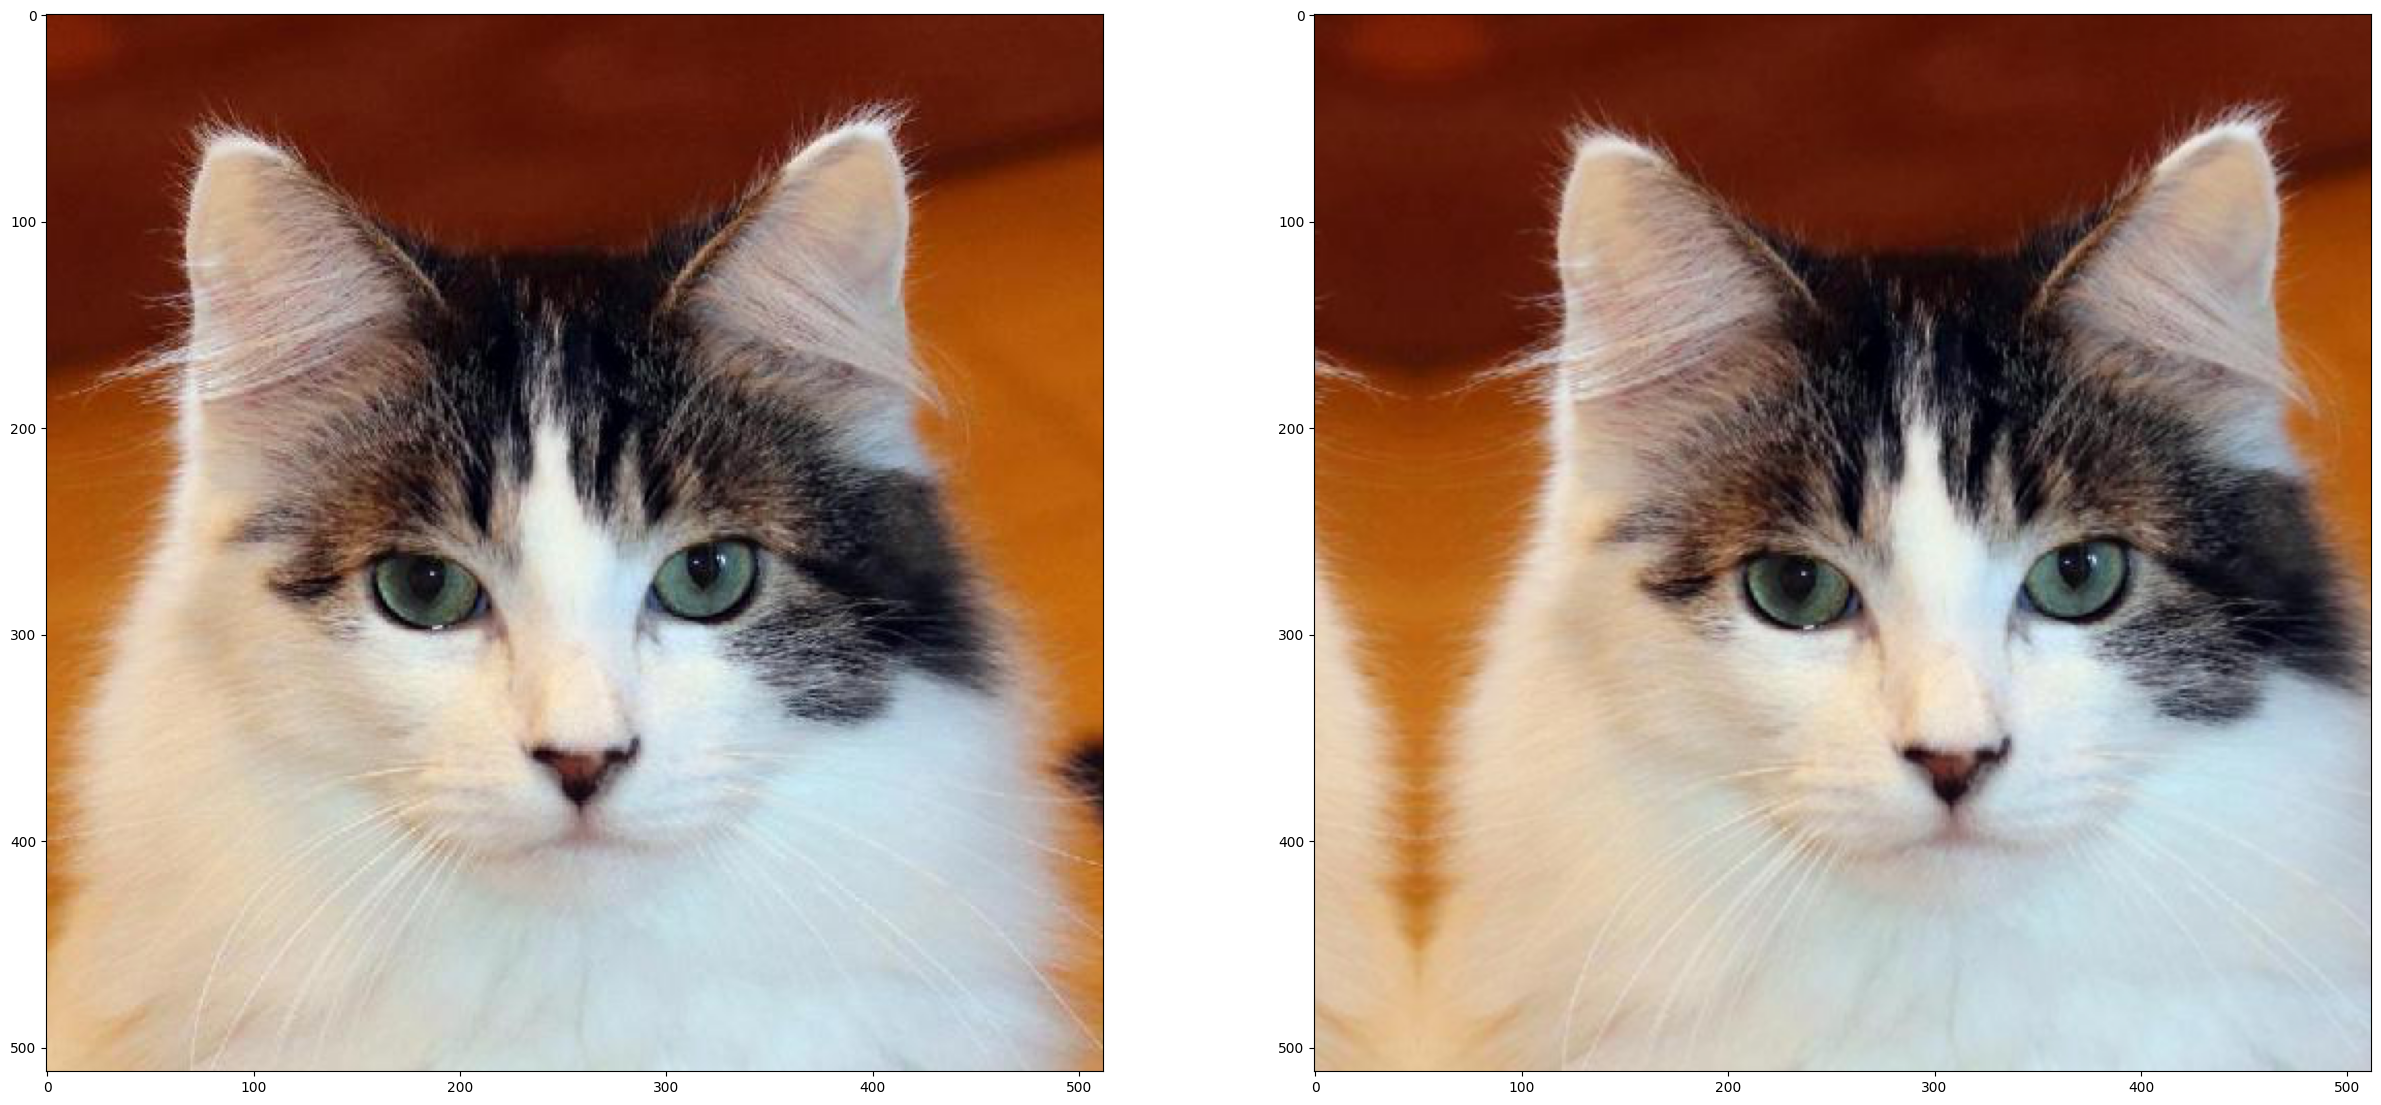

In [10]:
# Rigid body transformation
# x' = Rx+t

angle = torch.ones(1) * 0.0
scale = torch.ones(1)
center = torch.ones(1, 2)

img_size = torch_img.shape[2:]
x, y = 256.0, 256.0
center[0][0] = x
center[0][1] = y

# Rigid transformation
translation_vector = torch.zeros_like(center)
translation_vector[0][0] = 50.0
translation_vector[0][1] = 0.0
rigid_mat = warper.get_rotation_matrix2d(center.to(torch_img), angle.to(torch_img), scale.to(torch_img), translation_vector.to(torch_img))
rotated_img = warper.warp_affine(torch_img, 
                               rigid_mat, 
                               dsize=(img_size[0], img_size[1]), 
                               interpolation_mode="bilinear", 
                               padding_mode="reflection")

fig, ax = plt.subplots(1, 2, figsize=(30, 30))
ax[0].imshow(torch_to_pil(torch_img))
ax[1].imshow(torch_to_pil(rotated_img))

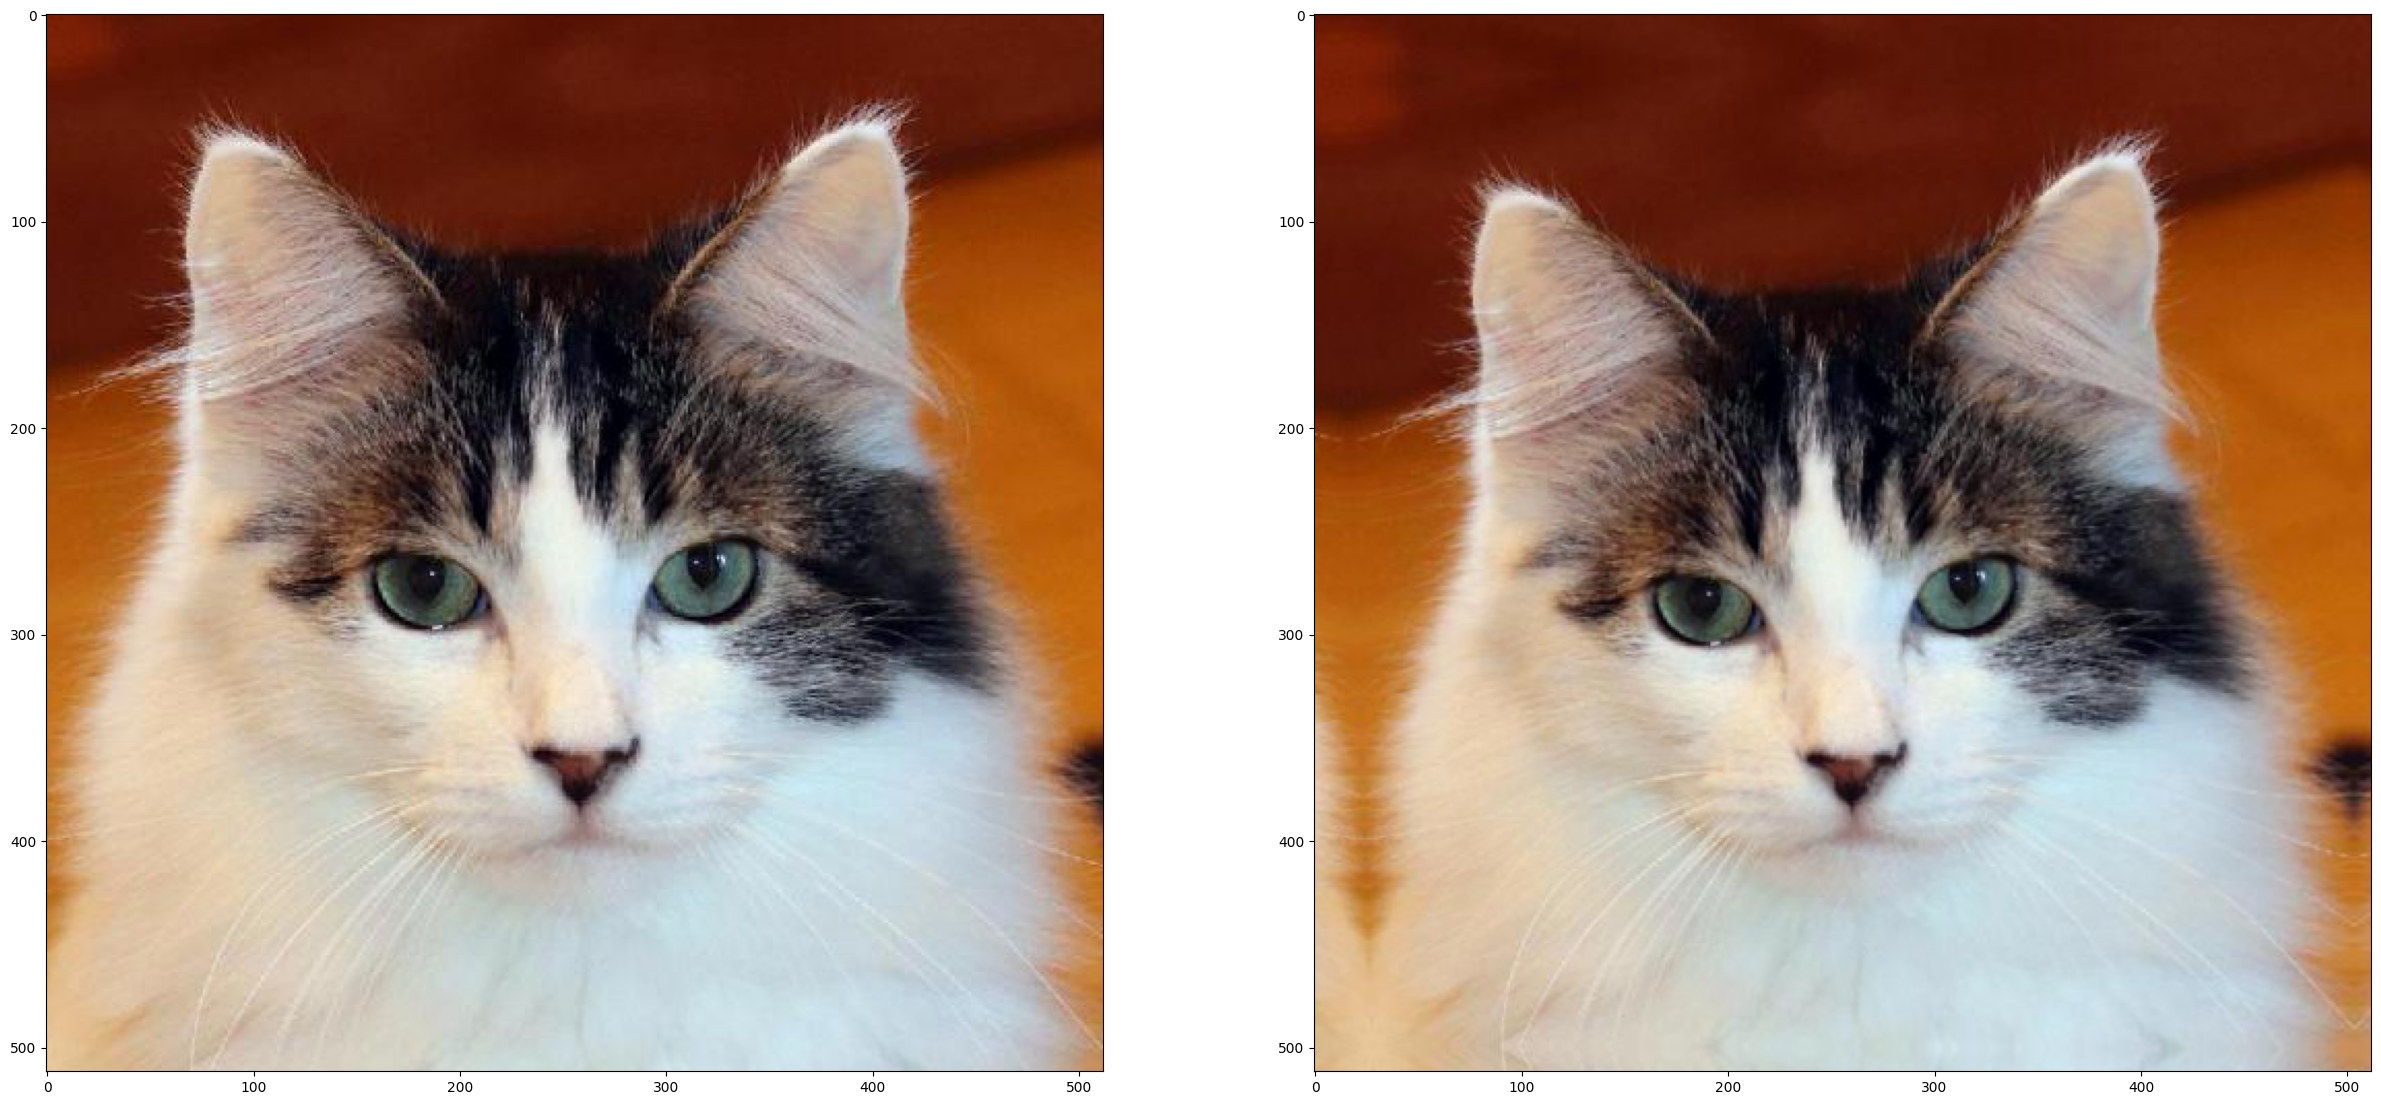

In [12]:
# Perspective transformation
# 8-point algorithm

PERSPECTIVE_DISPLACEMENT = 40
img_size = torch_img.shape[2:]
w, h = img_size
assert w == h

# Homography transformation
translation_vector = torch.zeros_like(center)
translation_vector[0][0] = 50.0
translation_vector[0][1] = 0.0

# x, y flipped
points_src = torch.FloatTensor([[[0, 0], [w-1, 0], [0, h-1], [w - 1, h - 1]]]).to(device)
points_dir = torch.FloatTensor([[[1, 1], [-1, 1], [1, -1], [-1, -1]]]).to(device)
points_displacement = torch.rand_like(points_src).to(device) * (PERSPECTIVE_DISPLACEMENT)
points_displacement *= points_dir
points_dst = points_src + points_displacement

pers_mat = warper.get_perspective_transform(points_src, points_dst)


pers_img = warper.warp_perspective(torch_img, 
                                      pers_mat, 
                                      dsize=(img_size[0], img_size[1]), 
                                      interpolation_mode="bilinear", 
                                      padding_mode="reflection")


fig, ax = plt.subplots(1, 2, figsize=(30, 30))
ax[0].imshow(torch_to_pil(torch_img))
ax[1].imshow(torch_to_pil(pers_img))